In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from minopy.objects.invert_pixel import process_pixel 
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [6]:
project_dir = './../DATA/Miami_data'
out_dir = './out_figures'
#os.chdir(project_dir)

geom_dsm = project_dir + '/dsm_reprojected_wgs84.tif'

out_amplitude = project_dir + '/mean_amplitude'

plt.rcParams["font.size"] = "25"

In [7]:
def get_data(lats, lons, box_rdr, ps, out_amplitude, shift=0, corrected=False):
    demError_file = project_dir + '/demErr.h5'
    demError_std_file = project_dir + '/demErr_std.h5'

    vel_file = project_dir + '/velocity.h5'
    if corrected:
        geo_file = project_dir + '/corrected_geo/geometryRadar.h5'
        print('corrected')
    else:
        print('not corrected')
        geo_file = project_dir + '/org_geometry/geometryRadar.h5'

    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    
    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    DEM = readfile.read(geo_file, datasetName='height')[0]+26
    
    demError = readfile.read(demError_file, datasetName='dem')[0]
    demError_std = readfile.read(demError_std_file, datasetName='dem')[0]

    velocity, atr = readfile.read(vel_file, datasetName='velocity')
    velocity -= velocity[refy, refx]

    mask = np.ones(velocity.shape, dtype=np.int8)
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0
    
    
    xmin = box_rdr[0]
    xmax = box_rdr[1]
    ymin = box_rdr[2]
    ymax = box_rdr[3]
    
    am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))

    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask *= mask_p
    else:
        mask *= mask_t
    
    
    vel = np.array(velocity[mask==1]*1000)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    demerr = np.array(demError[mask==1])
    demerror_std = np.array(demError_std[mask==1])
    dem = np.array(DEM[mask==1])
    
    
    mask = np.zeros(velocity.shape)
    mask[ymin:ymax, xmin:xmax] = 1
    
    if ps:
        mask *= mask_p
    else:
        mask *= mask_t
    
    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)
    
    xv = np.array(x[mask==1])-xmin
    yv = ymax - np.array(y[mask==1])-1
    ddemerr = np.array(demError[mask==1])
    ddem = np.array(DEM[mask==1])
  
    return amplitude, xv, yv, lon, lat, vel, demerr, demerror_std, dem, ddemerr, ddem



def plot_subset(box,  box_rdr, ps, vel_range, amplitude_im, dem_offset, 
                dem_name, out_name, out_dir, f1, f2, corrected,ampmax=300, pdd=0.08):
    
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    padding=0.02
    scale=70
    
    amplitude,  xv, yv, lon, lat, vel, demerr, demerror_std, dem , ddemerr, ddem = get_data(lats, lons,box_rdr, ps, amplitude_im, dem_offset, corrected)
    amplitudep,  xvp, yvp, lonp, latp, velp, demerrp, demerror_stdp, demp , ddemerrp, ddemp = get_data(lats, lons,box_rdr, True, amplitude_im, dem_offset, corrected)
        
    
    opt = ' --notitle --fontsize 12 --nocbar --alpha 1 '
    opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray' # -u cm '
    opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
    opt += ' --noverbose --noreference --noscalebar' #.format(reflat, reflon)
    
    
    data_mud2 = project_dir + '/geo/geo_velocity.h5'
    mask_ps_file = project_dir + '/geo/geo_maskPS.h5'
    
    
    cmd = 'view.py {} '.format(geom_dsm) + opt 
    #cmd += ' --dem {} --dem-nocontour --contour-smooth 0.0 --shade-az 45 '.format(geom_dsm)
    #cmd += ' --shade-exag 0.01 --shade-min 0 --shade-max 30 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lats[0], lats[1], lons[0], lons[1])
    
    
    
    fig, _axs = plt.subplots(nrows=1, ncols=4, 
                        figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    axs = _axs.flatten()
    
    
    ax1 = axs[0]
    ax1.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax1, d_v, atr, inps)[2:4]
    
    
    ax2 = axs[1]

    
    ax3 = axs[2]
    ax3.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax3, d_v, atr, inps)[2:4]
    
    ax4 = axs[3]
    ax4.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax4, d_v, atr, inps)[2:4]
    
    
    #####  1
    im2 = ax1.scatter(lonp, latp, c=velp, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range);
    im = ax1.scatter(lon, lat, c=vel, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range); 
    im.set_zorder(20)
    im2.set_zorder(25)
    
    geo_box = (lons[0], lats[0], lons[1], lats[1])
    pp.draw_scalebar(ax1, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    cbar = plt.colorbar(im, ax=ax1, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('velocity [mm/yr]')
    #cbar.set_label('DEM Error [m]')
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    
    #####   2
    imm=ax2.imshow(amplitudep, cmap='gray', vmin=0, vmax=ampmax, origin='upper')
    
    im = ax2.scatter(xv, yv, c=-ddemerr+ddem, s=scale, cmap='jet'); 
    im.set_zorder(20)
    im1 = ax2.scatter(xvp, yvp, c=-ddemerrp+ddemp, s=scale, cmap='jet'); 
    im1.set_zorder(20)
    cbar = plt.colorbar(im1, ax=ax2, shrink=0.6, orientation='horizontal', pad=pdd)
    cbar.set_label('Estimated \nelevation [m]')
           
    cbar_ax = fig.add_axes([0.35, 0.8, 0.1, 0.018])
    fig.colorbar(imm, cax=cbar_ax, ticks=[0, ampmax], label='Amplitude', 
                 orientation='horizontal', pad=padding)
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_label_position('top')
 
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    
    #####   3
    im1 = ax3.scatter(lon, lat, c=-demerr+dem, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(20)
    im2 = ax3.scatter(lonp, latp, c=-demerrp+demp, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im2.set_zorder(25)
        
    cbar = plt.colorbar(im1, ax=ax3, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('Estimated \nelevation [m]')
    #cbar.set_label('Elevation [m]')
    #pp.draw_scalebar(ax3, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    
    #####   4
    #im = ax3.scatter(lon, lat, c=-demerr, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im = ax4.scatter(lon, lat, c=demerror_std, s=scale, cmap='jet', vmin=0, vmax=20); 
    im.set_zorder(20)
    im1 = ax4.scatter(lonp, latp, c=demerror_stdp, s=scale, cmap='jet', vmin=0, vmax=20); 
    #im1 = ax3.scatter(lonp, latp, c=-demerrp, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(25)
    cbar = plt.colorbar(im, ax=ax4, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('DEM error \nSTD [m]')
    ax4.axes.get_xaxis().set_visible(False)
    ax4.axes.get_yaxis().set_visible(False)
    
    

    
    if ps:
        psds = 'ps'
    else:
        psds = 'ds'
    plt.savefig(out_dir + '/{}_{}_{}.png'.format(out_name, dem_name, psds),bbox_inches='tight', dpi=300)
    
    

not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30


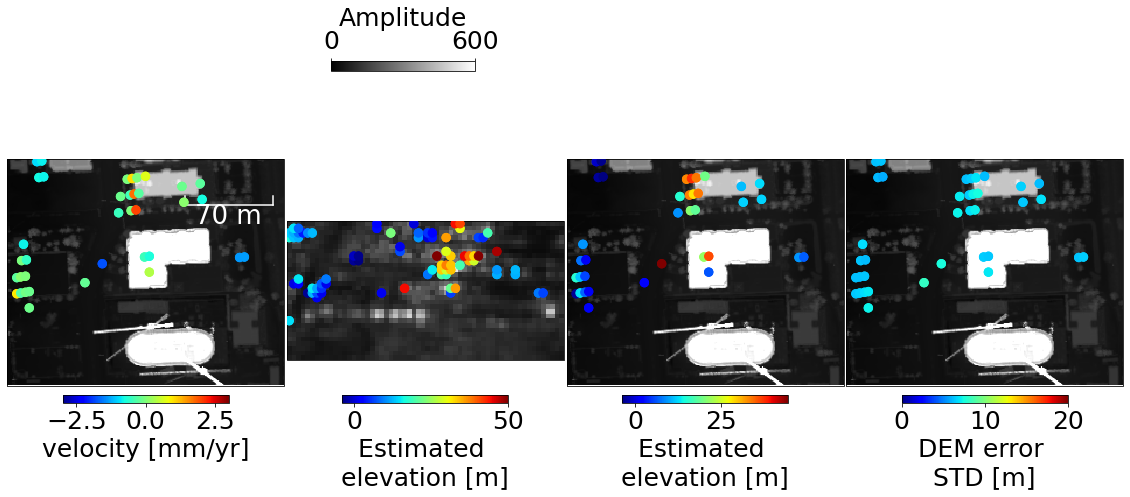

In [12]:
refy = 295
refx = 1467
box = ['25.8719:25.8737','-80.1222:-80.1200']
box_rdr = [1460, 1520, 280, 310]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_champlain_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30


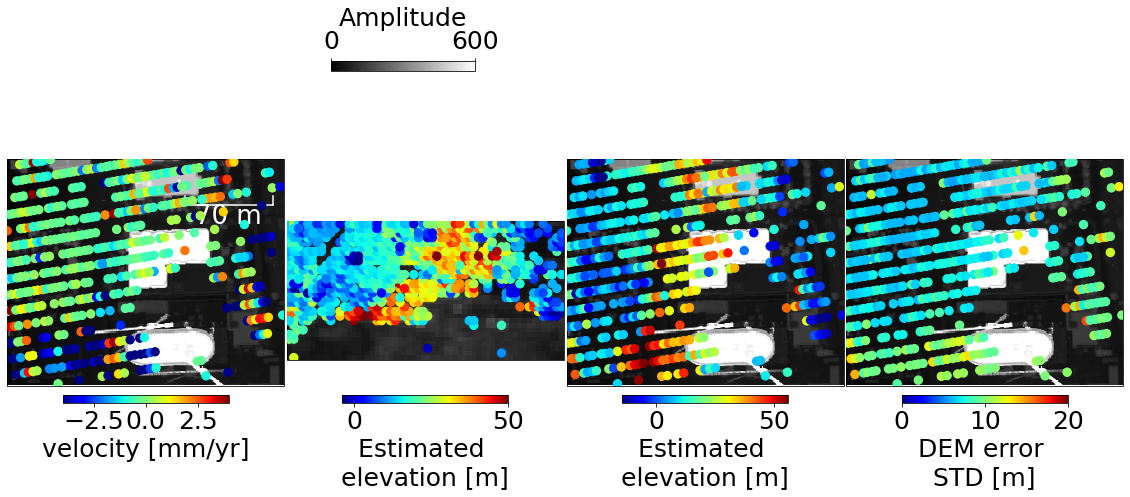

In [16]:
refy = 295
refx = 1467
box = ['25.8719:25.8737','-80.1222:-80.1200']
box_rdr = [1460, 1520, 280, 310]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=4, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_champlain_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30


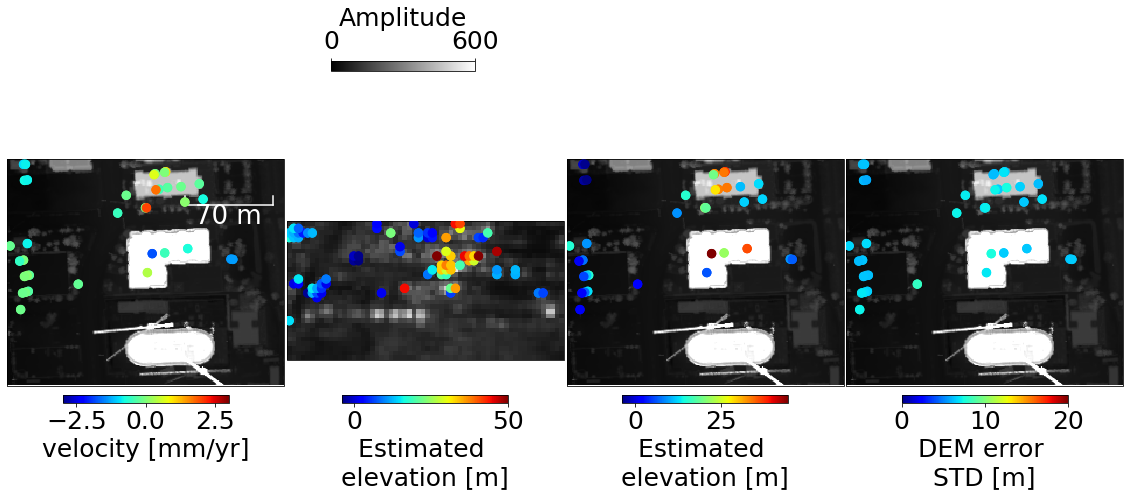

In [14]:
refy = 295
refx = 1467
box = ['25.8719:25.8737','-80.1222:-80.1200']
box_rdr = [1460, 1520, 280, 310]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_champlain_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8719 25.8737 --sub-lon -80.1222 -80.12 -v 0 30


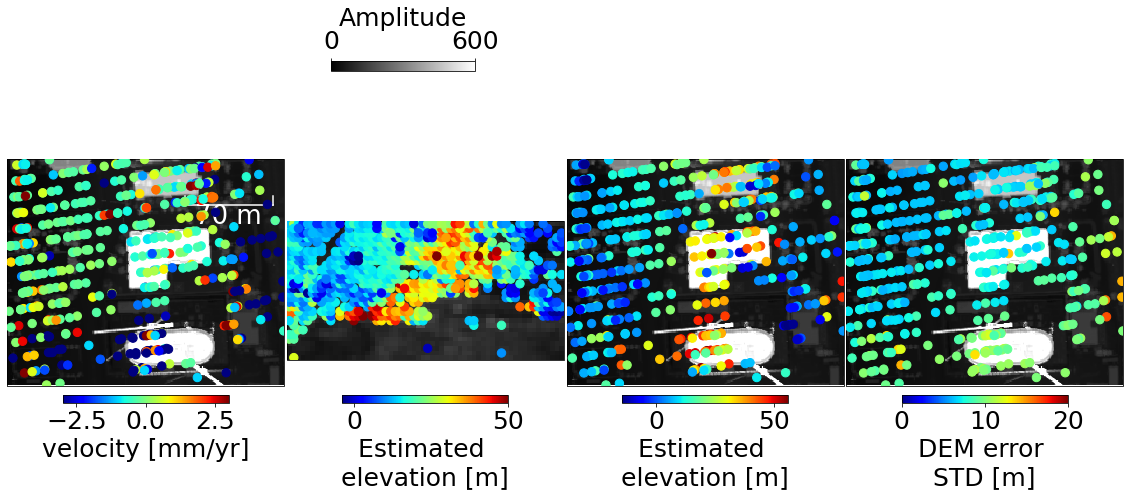

In [15]:
refy = 295
refx = 1467
box = ['25.8719:25.8737','-80.1222:-80.1200']
box_rdr = [1460, 1520, 280, 310]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_champlain_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)

not corrected
not corrected
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 40
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 40
view.py ./../DATA/Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 40


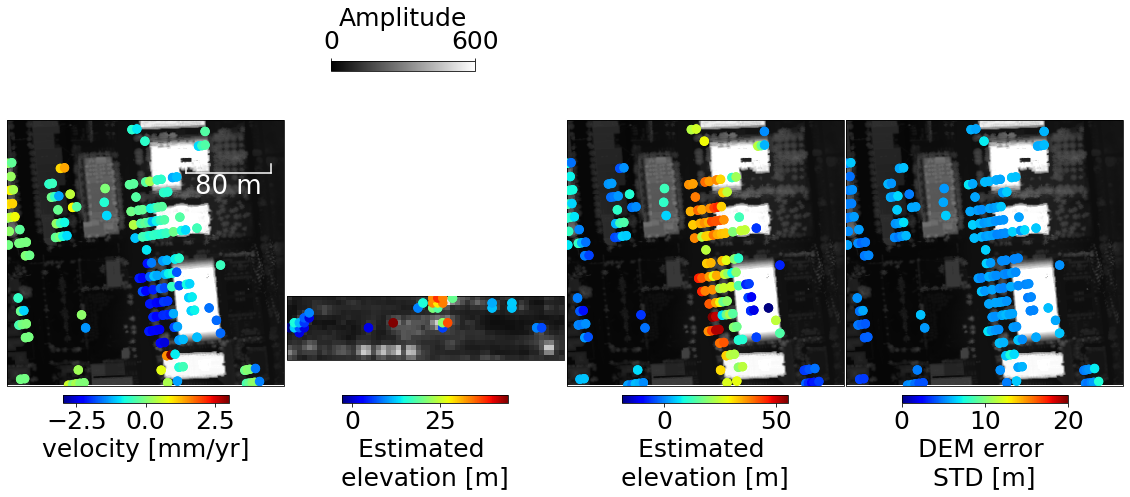

In [10]:
refy = 381
refx = 1499
box = ['25.8822:25.8847','-80.1236:-80.1210']
box_rdr = [1464, 1520, 288, 301]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_grandbeach_geolocation', 
            out_dir=out_dir, f1=0, f2=40, corrected=False, ampmax=600)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30


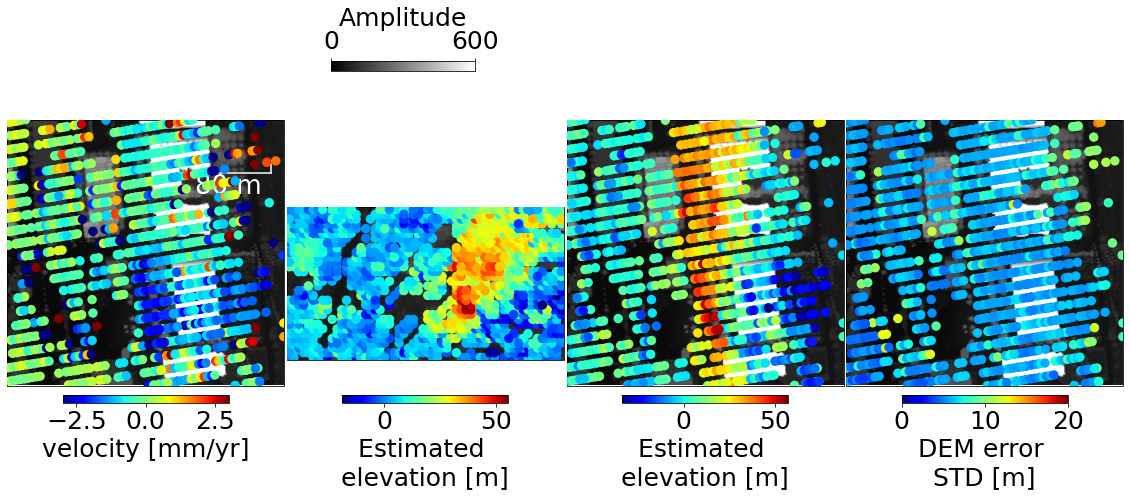

In [23]:
refy = 381
refx = 1499
box = ['25.8822:25.8847','-80.1236:-80.1210']
box_rdr = [1482, 1540, 363, 395]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_grandbeach_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)

corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30


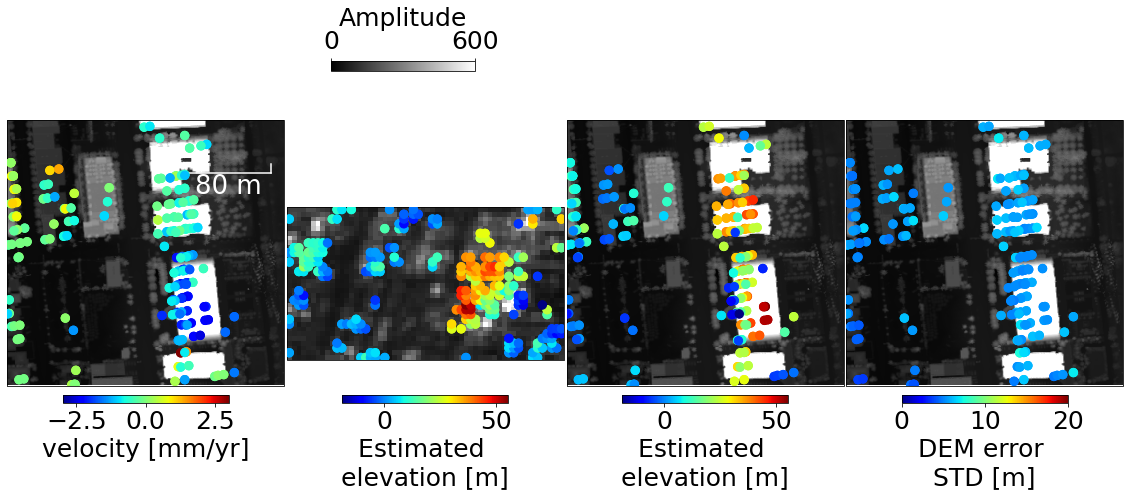

In [24]:
refy = 381
refx = 1499
box = ['25.8822:25.8847','-80.1236:-80.1210']
box_rdr = [1482, 1540, 363, 395]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_grandbeach_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)

corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8822 25.8847 --sub-lon -80.1236 -80.121 -v 0 30


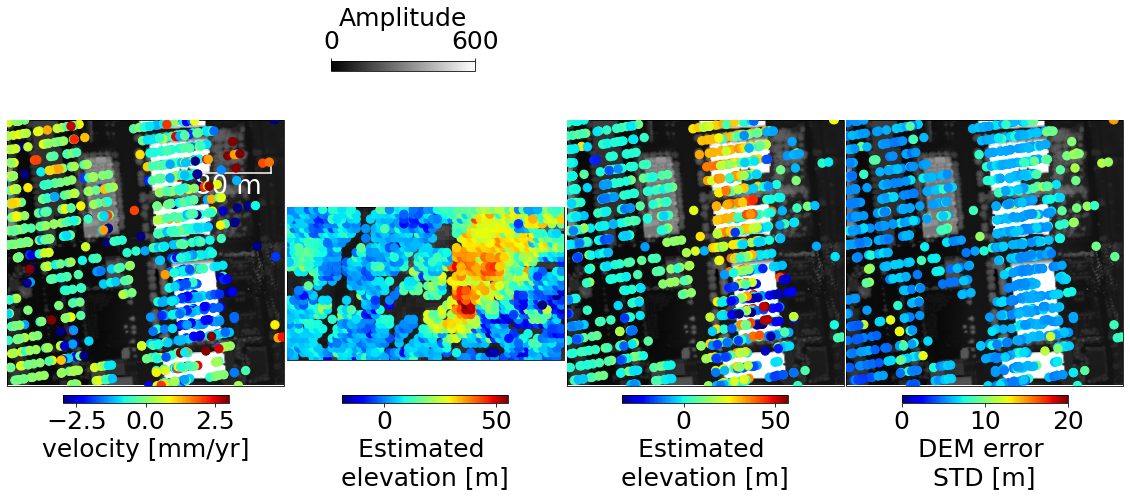

In [25]:
refy = 381
refx = 1499
box = ['25.8822:25.8847','-80.1236:-80.1210']
box_rdr = [1482, 1540, 363, 395]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_grandbeach_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)

not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30


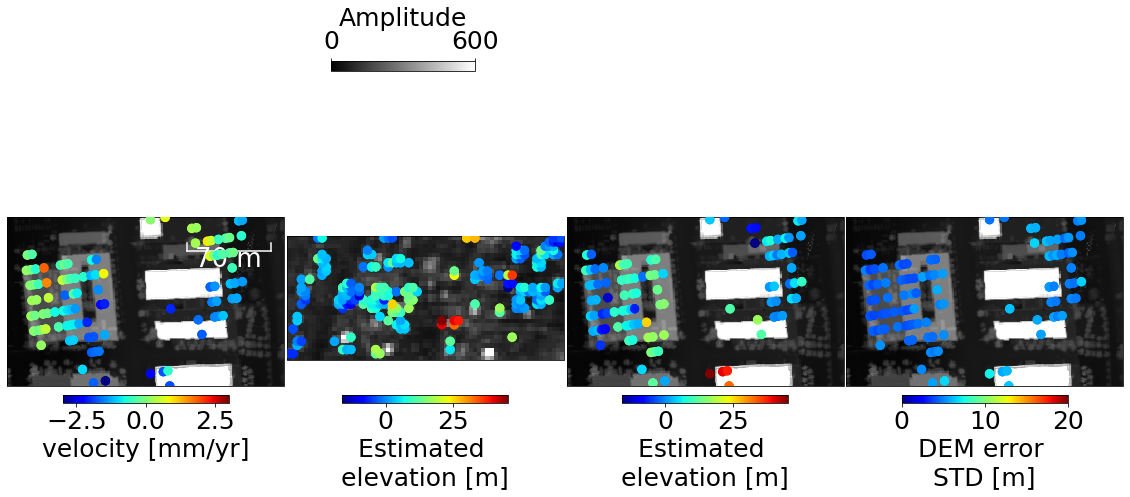

In [14]:
refy = 357
refx = 1487
box = ['25.8796:25.8810','-80.1231:-80.1208']
box_rdr = [1473, 1540, 340, 370]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_residence_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30


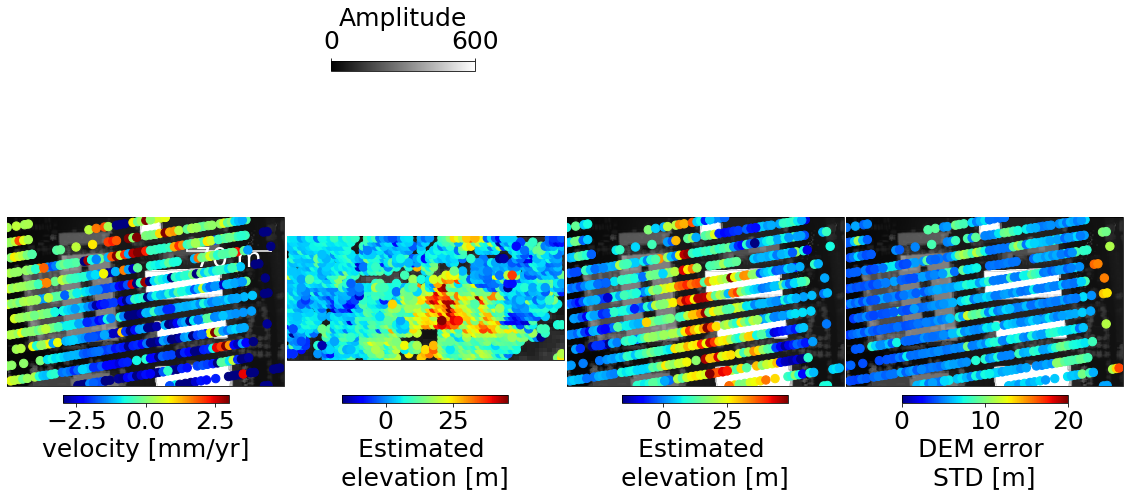

In [17]:
refy = 357
refx = 1487
box = ['25.8796:25.8810','-80.1231:-80.1208']
box_rdr = [1473, 1540, 340, 370]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_residence_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30


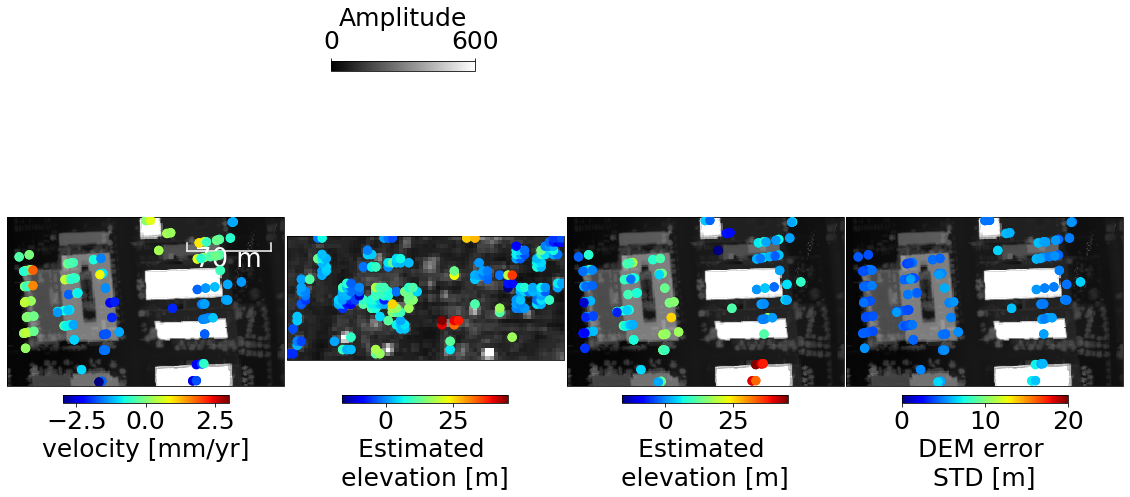

In [18]:
refy = 357
refx = 1487
box = ['25.8796:25.8810','-80.1231:-80.1208']
box_rdr = [1473, 1540, 340, 370]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_residence_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8796 25.881 --sub-lon -80.1231 -80.1208 -v 0 30


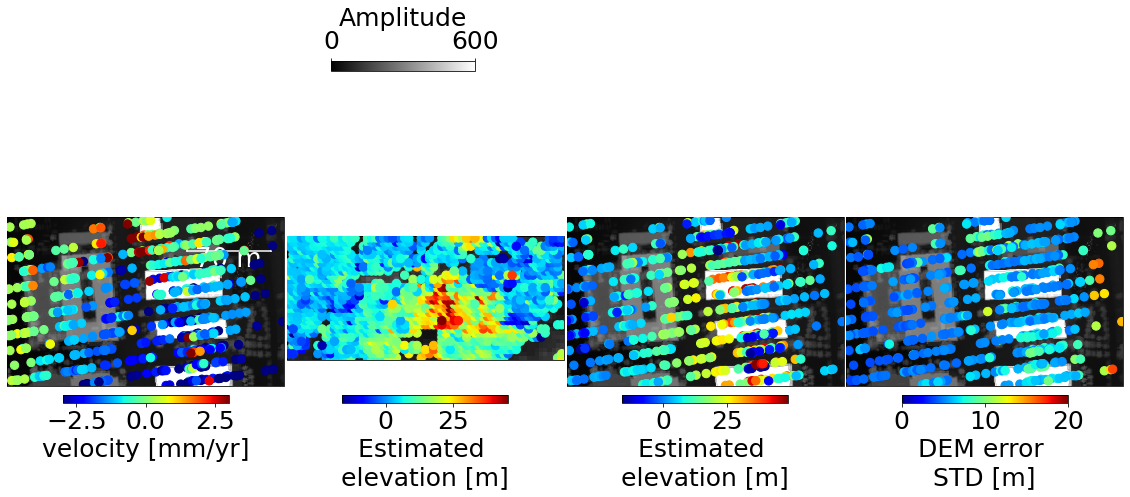

In [19]:
refy = 357
refx = 1487
box = ['25.8796:25.8810','-80.1231:-80.1208']
box_rdr = [1473, 1540, 340, 370]
plot_subset(box=box, box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_residence_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True, ampmax=600)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30


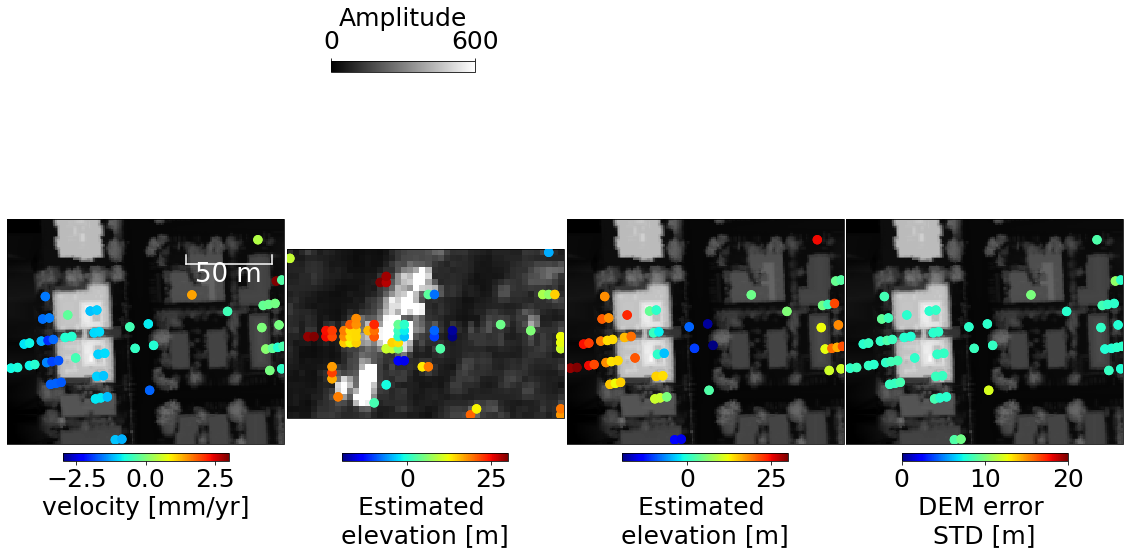

In [372]:
refy = 443
refx = 1257
box = ['25.8893:25.8906','-80.1342:-80.1326']
box_rdr = [1212, 1258, 430, 458]
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_Kai_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False, ampmax=600)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30


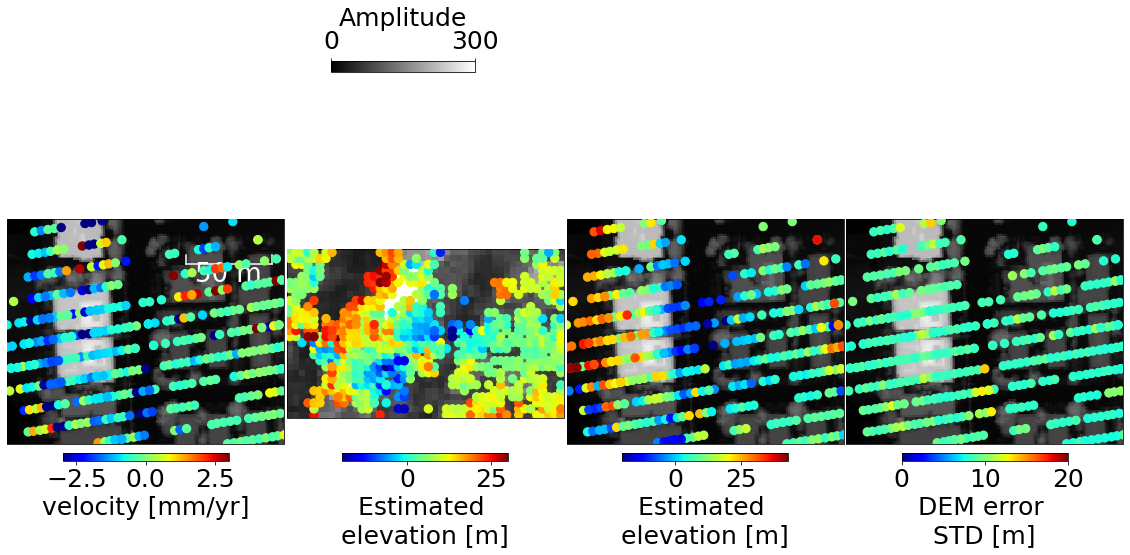

In [373]:
refy = 443
refx = 1257
box_rdr = [1212, 1258, 430, 458]

box = ['25.8893:25.8906','-80.1342:-80.1326']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_Kai_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=False)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30


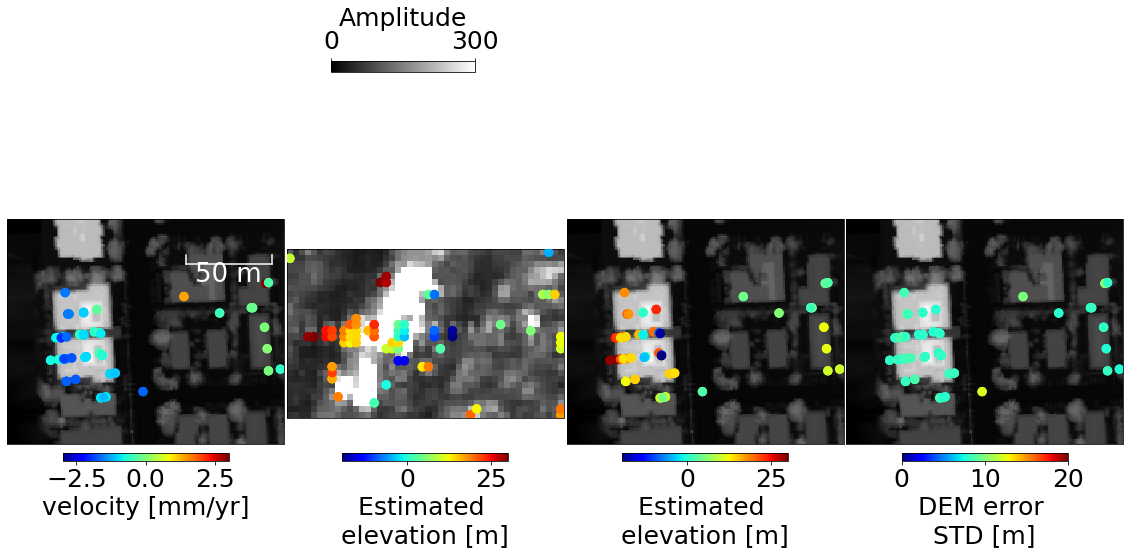

In [374]:
refy = 443
refx = 1257
box_rdr = [1212, 1258, 430, 458]

box = ['25.8893:25.8906','-80.1342:-80.1326']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_Kai_geolocation_corrected', 
            out_dir=out_dir, f1=0, f2=30, corrected=True)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8893 25.8906 --sub-lon -80.1342 -80.1326 -v 0 30


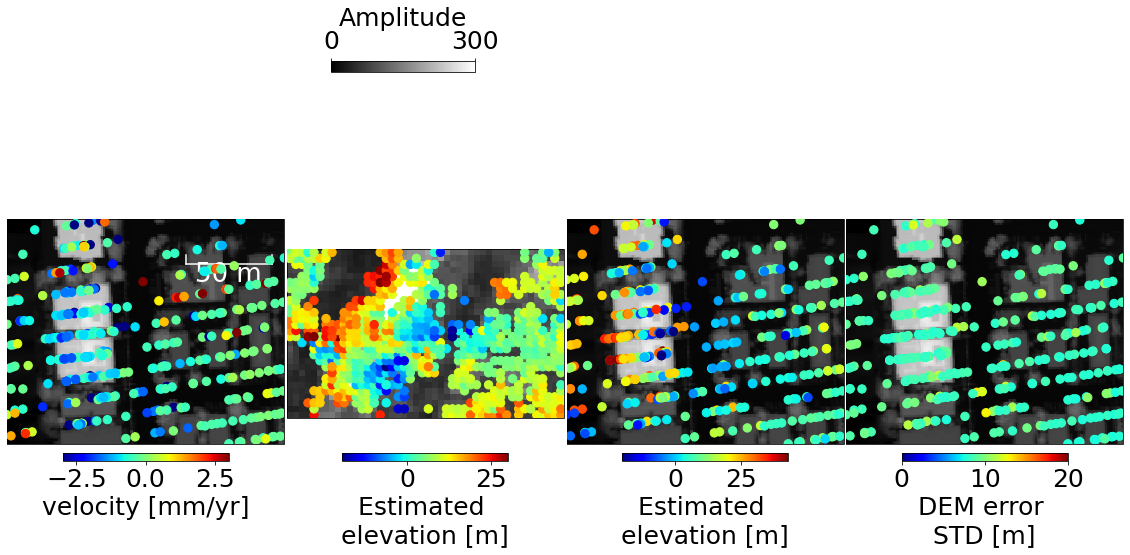

In [375]:
refy = 443
refx = 1257
box_rdr = [1212, 1258, 430, 458]

box = ['25.8893:25.8906','-80.1342:-80.1326']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=3, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_Kai_geolocation', 
            out_dir=out_dir, f1=0, f2=30, corrected=True)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120


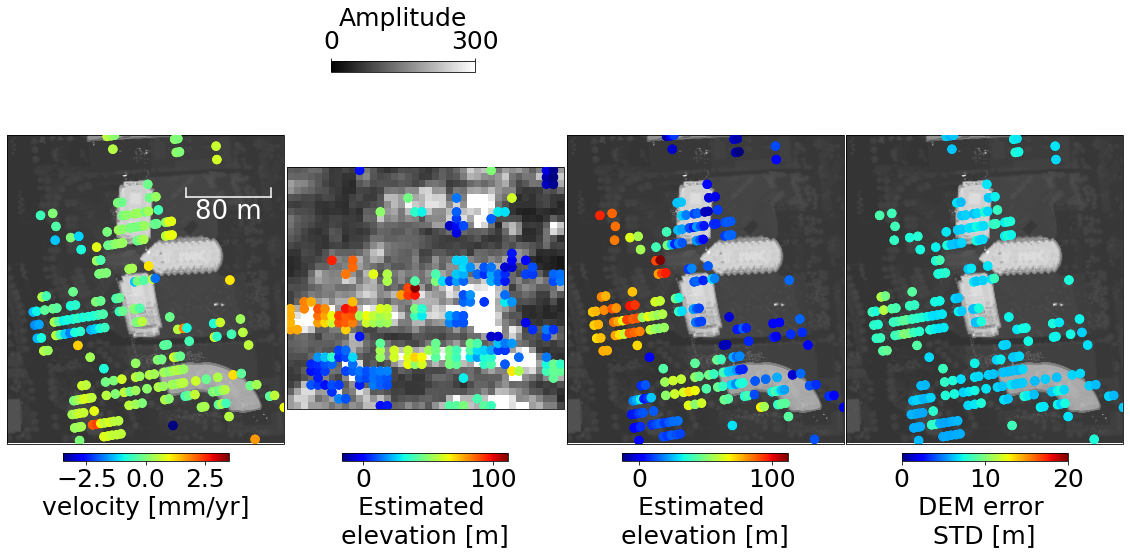

In [376]:
refy = 412
refx = 1509
box_rdr = [1505, 1545, 405, 440]
box = ['25.8871:25.8900','-80.1241:-80.1215']
plot_subset(box=box, box_rdr=box_rdr,ps=True, vel_range=3.5, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_StRegis_geolocation', 
            out_dir=out_dir, f1=-30, f2=120, corrected=False, pdd=0.1)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120


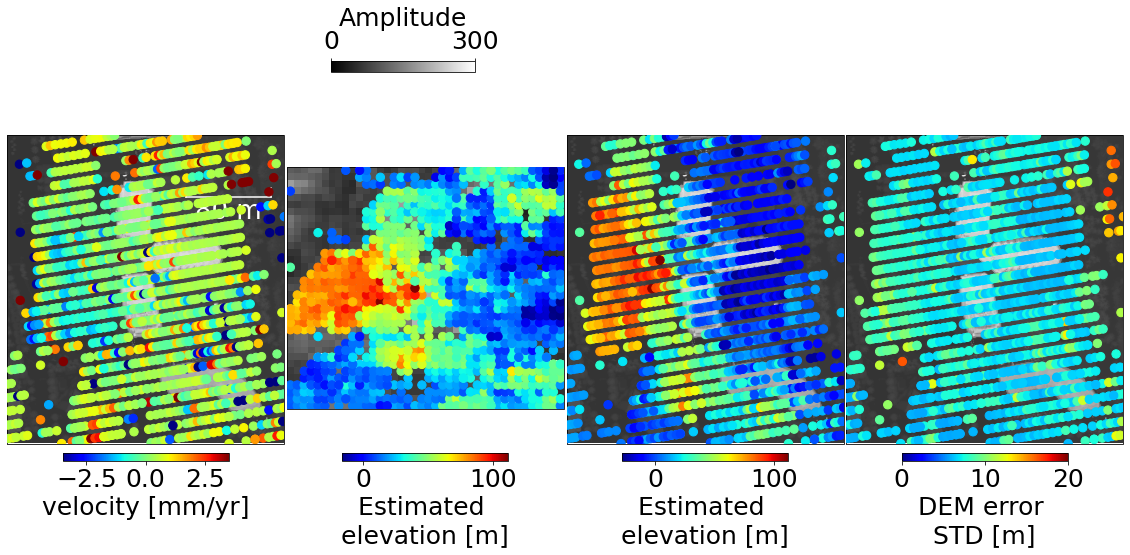

In [377]:
refy = 412
refx = 1509
box_rdr = [1505, 1545, 405, 440]
box = ['25.8871:25.8900','-80.1241:-80.1215']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=3.5, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_StRegis_geolocation', 
            out_dir=out_dir, f1=-30, f2=120, corrected=False, pdd=0.1)

corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120


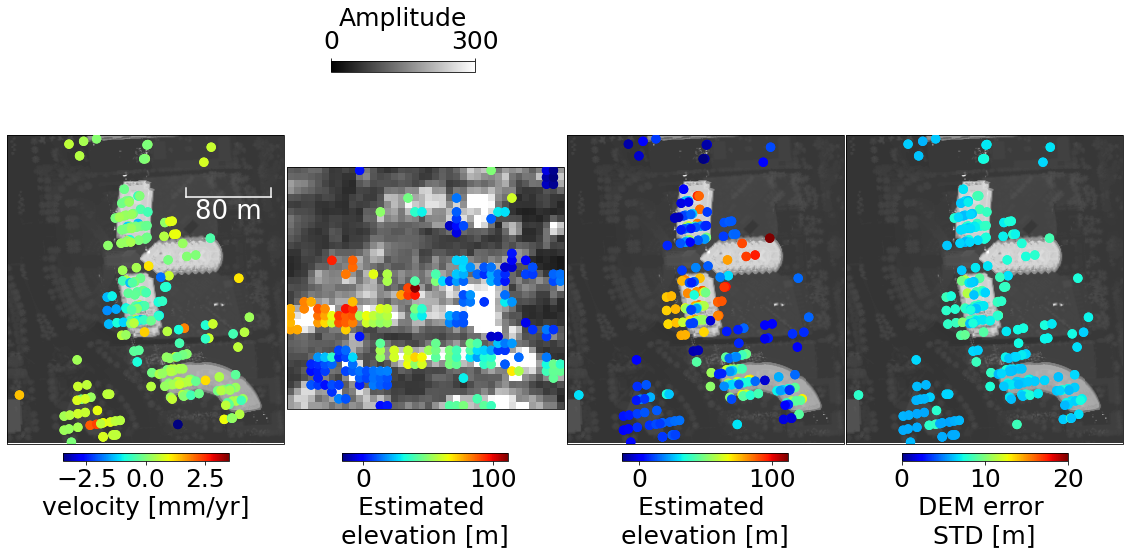

In [378]:
refy = 412
refx = 1509
box_rdr = [1505, 1545, 405, 440]
box = ['25.8871:25.8900','-80.1241:-80.1215']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=3.5, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_StRegis_geolocation_corrected', 
            out_dir=out_dir, f1=-30, f2=120, corrected=True,pdd=0.1)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8871 25.89 --sub-lon -80.1241 -80.1215 -v -30 120


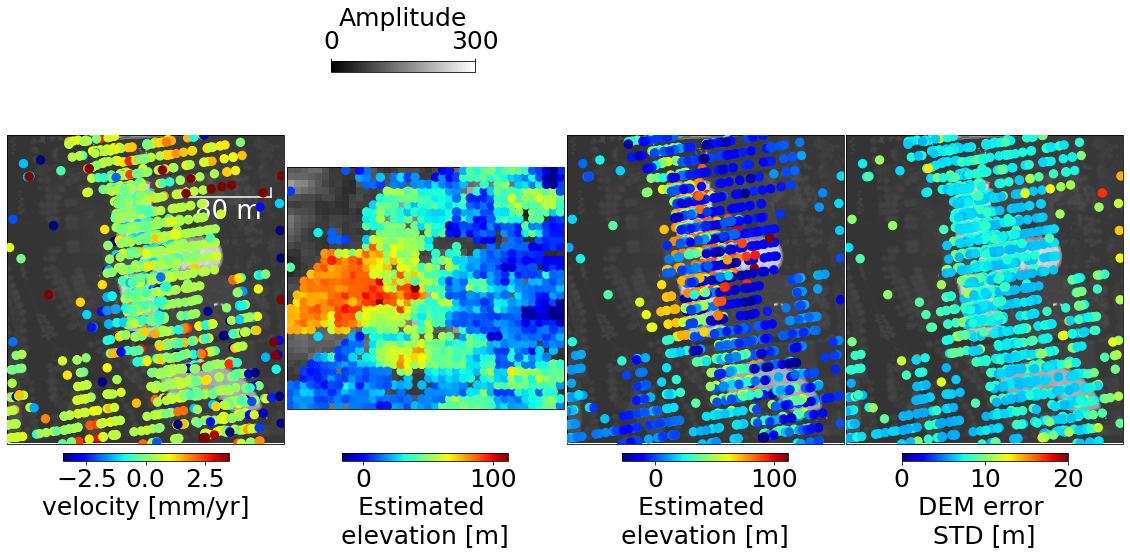

In [379]:
refy = 412
refx = 1509
box_rdr = [1505, 1545, 405, 440]
box = ['25.8871:25.8900','-80.1241:-80.1215']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=3.5, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_StRegis_geolocation_corrected', 
            out_dir=out_dir, f1=-30, f2=120, corrected=True,pdd=0.1)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120


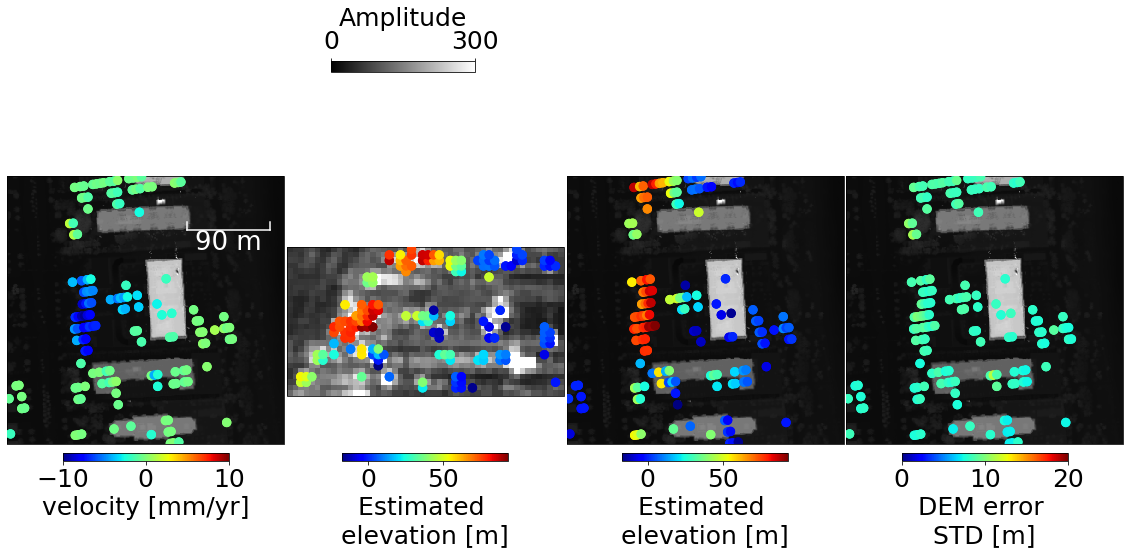

In [380]:
refy = 465
refx = 1538
box_rdr = [1530, 1580, 458, 485]
box = ['25.8936:25.8965','-80.1247:-80.1217']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_oceana_geolocation', 
            out_dir=out_dir, f1=-5, f2=120, corrected=False, pdd=0.13)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120


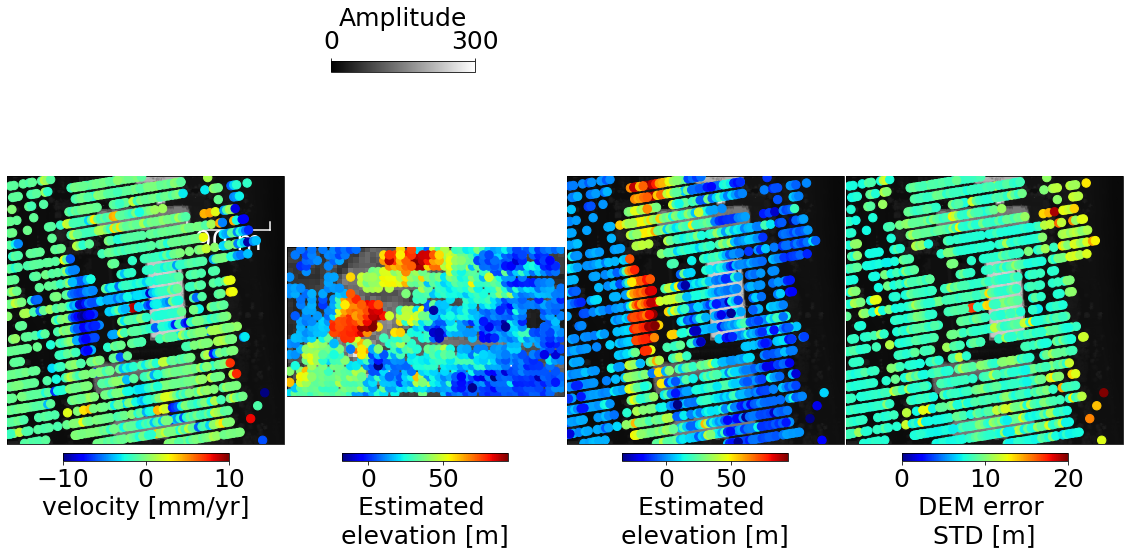

In [381]:
refy = 465
refx = 1538
box_rdr = [1530, 1580, 458, 485]
box = ['25.8936:25.8965','-80.1247:-80.1217']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_oceana_geolocation', 
            out_dir=out_dir, f1=-5, f2=120, corrected=False, pdd=0.13)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120


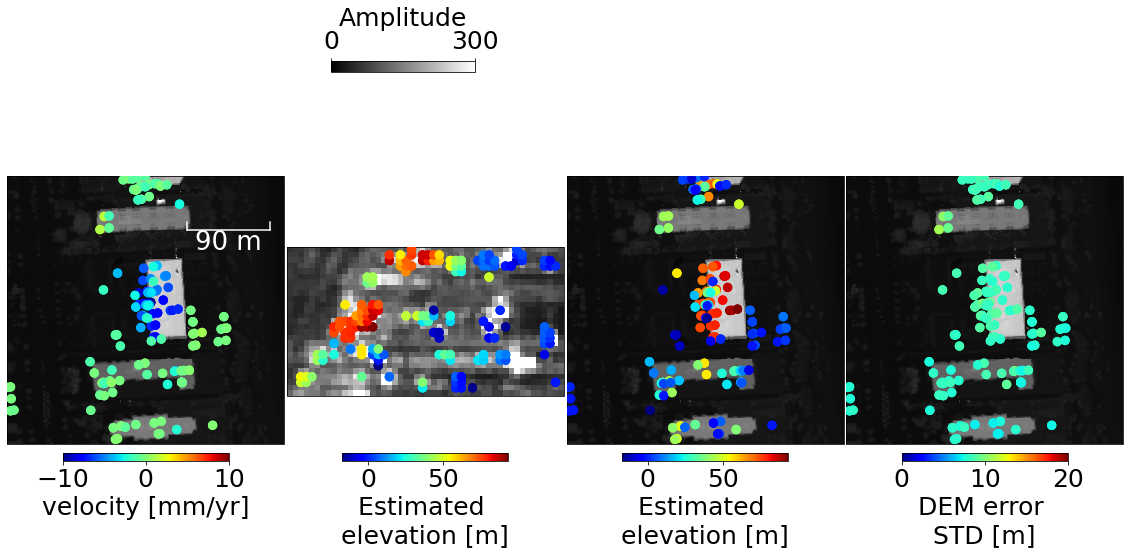

In [382]:
refy = 465
refx = 1538
box_rdr = [1530, 1580, 458, 485]
box = ['25.8936:25.8965','-80.1247:-80.1217']
plot_subset(box=box, box_rdr=box_rdr, ps=True, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_oceana_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=120, corrected=True, pdd=0.13)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.8936 25.8965 --sub-lon -80.1247 -80.1217 -v -5 120


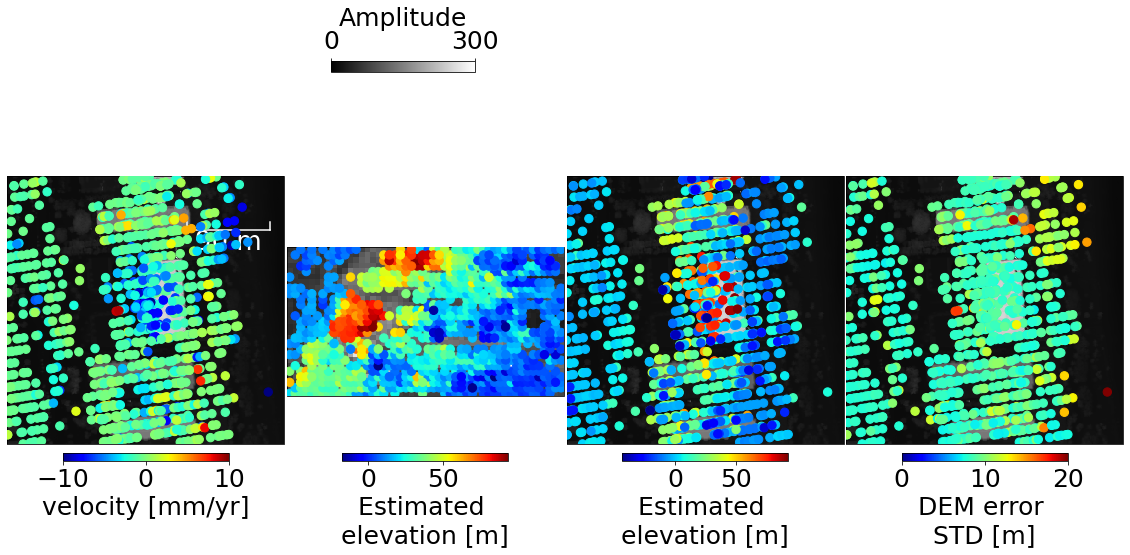

In [383]:
refy = 465
refx = 1538
box_rdr = [1530, 1580, 458, 485]
box = ['25.8936:25.8965','-80.1247:-80.1217']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_oceana_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=120, corrected=True, pdd=0.13)


not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


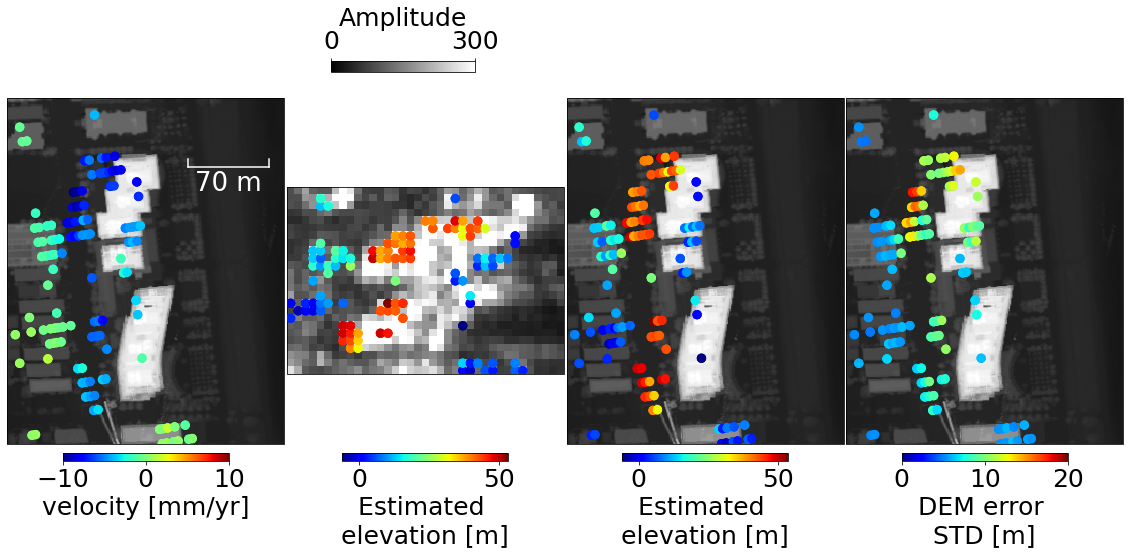

In [384]:
efy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation', 
            out_dir=out_dir, f1=-5, f2=50, corrected=False, pdd=0.18)



not corrected
not corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


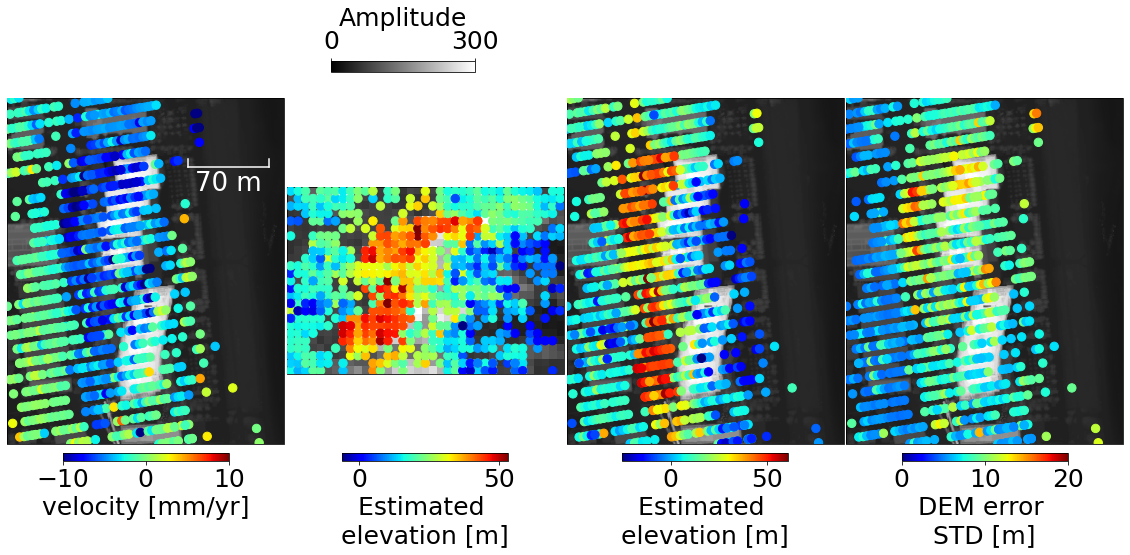

In [385]:
refy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation', 
            out_dir=out_dir, f1=-5, f2=50, corrected=False, pdd=0.18)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


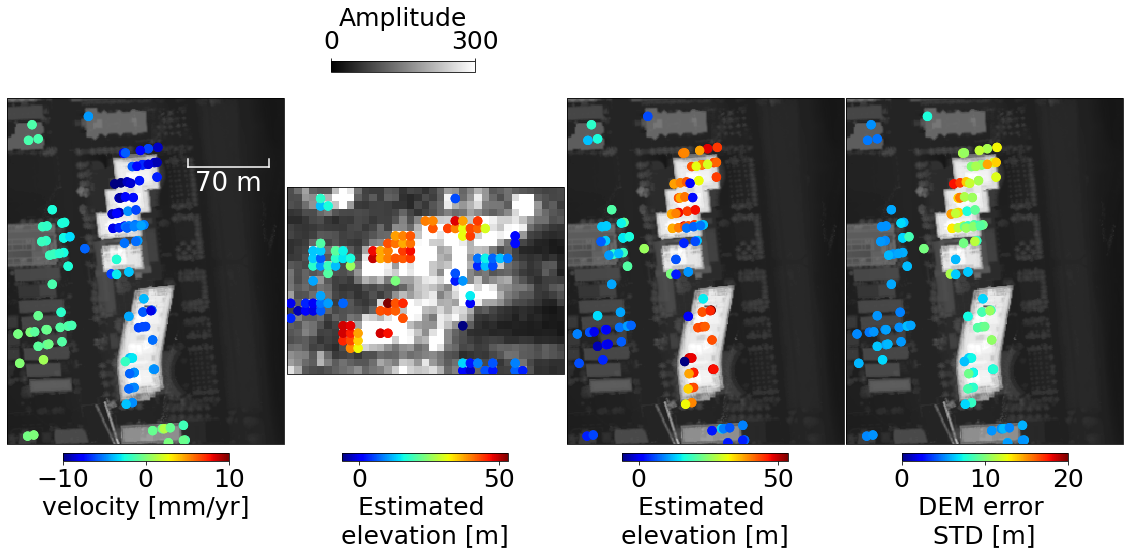

In [386]:
refy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=50, corrected=True, pdd=0.18)


corrected
corrected
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./Miami_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


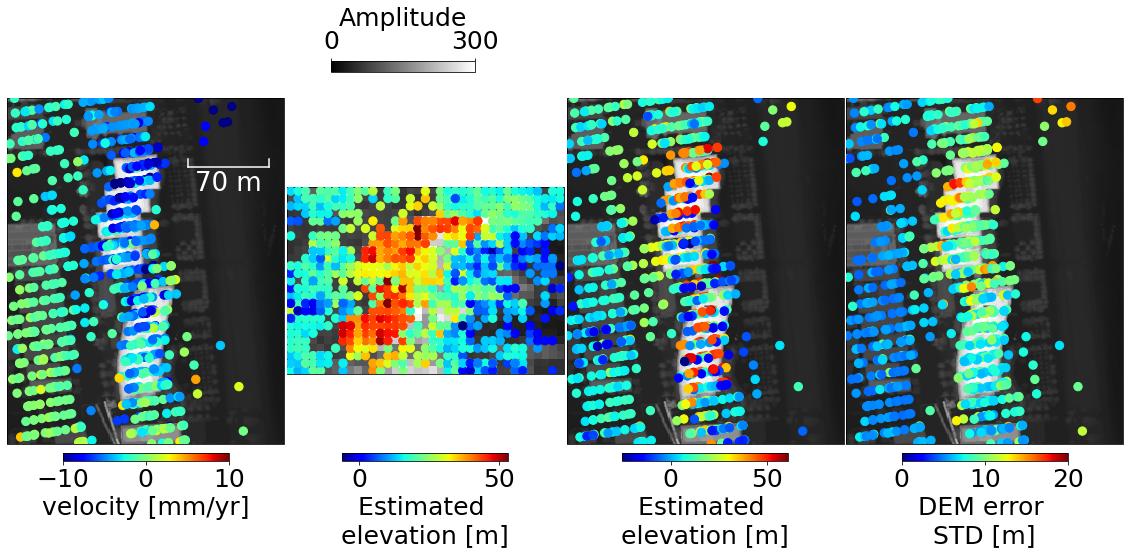

In [387]:
refy = 319
refx = 1489
box_rdr = [1490, 1527, 319, 344]
box = ['25.876:25.879','-80.1224:-80.120']
plot_subset(box=box,box_rdr=box_rdr, ps=False, vel_range=10, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_corrected', 
            out_dir=out_dir, f1=-5, f2=50, corrected=True, pdd=0.18)